# Logit Lens Investigation

Investigating Pythia-160m-deduped with "The capital of Ireland is" - looking at how "Dublin" logit builds across layers.

This uses the **logit lens** technique: apply the unembedding to intermediate residuals to see what the model would predict at each layer.

In [28]:
# Install HuggingFace transformers (simpler dependencies than transformer-lens)
# %pip install transformers torch

In [29]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load Pythia-150m-deduped from HuggingFace
model_name = "EleutherAI/pythia-160m-deduped"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
model.eval()

print(f"Model: {model_name}")
print(f"Layers: {model.config.num_hidden_layers}")
print(f"Heads: {model.config.num_attention_heads}")
print(f"d_model: {model.config.hidden_size}")

'(ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)), '(Request ID: 347ed3e5-4108-4fc8-a749-8b186d20b290)')' thrown while requesting HEAD https://huggingface.co/EleutherAI/pythia-160m-deduped/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
Retrying in 1s [Retry 1/5].


Model: EleutherAI/pythia-160m-deduped
Layers: 12
Heads: 12
d_model: 768


In [49]:
# Our test prompt
prompt = "The capital of Ireland is"
tokens = tokenizer(prompt, return_tensors="pt")
token_ids = tokens["input_ids"][0].tolist()
str_tokens = [tokenizer.decode([t]) for t in token_ids]

print(f"Tokens: {str_tokens}")
print(f"Token IDs: {token_ids}")

Tokens: ['The', ' capital', ' of', ' Ireland', ' is']
Token IDs: [510, 5347, 273, 11011, 310]


In [50]:
# Get the token ID for "Dublin" (with leading space)
dublin_tokens = tokenizer(" Dublin", add_special_tokens=False)["input_ids"]
print(f"' Dublin' token IDs: {dublin_tokens}")
dublin_token = dublin_tokens[0]  # Should be a single token
print(f"Using token ID: {dublin_token} = '{tokenizer.decode([dublin_token])}'")

' Dublin' token IDs: [24523]
Using token ID: 24523 = ' Dublin'


In [51]:
# Run the model and get all hidden states
with torch.no_grad():
    outputs = model(**tokens, output_hidden_states=True)

# outputs.hidden_states is a tuple: (embedding, layer_0_out, layer_1_out, ..., layer_L-1_out)
# So hidden_states[0] is after embedding, hidden_states[i+1] is after block i
hidden_states = outputs.hidden_states

print(f"Number of hidden states: {len(hidden_states)} (embedding + {len(hidden_states)-1} layers)")
print(f"Shape of each: {hidden_states[0].shape}")  # [batch, seq_len, d_model]

Number of hidden states: 13 (embedding + 12 layers)
Shape of each: torch.Size([1, 5, 768])


In [52]:
# Access the unembedding matrix and final layer norm
# In GPT-NeoX (Pythia's architecture):
#   - model.gpt_neox.final_layer_norm is the final LN
#   - model.embed_out is the unembedding (lm_head)

final_ln = model.gpt_neox.final_layer_norm
unembed = model.embed_out  # This is the lm_head / unembedding matrix

print(f"Final LN: {final_ln}")
print(f"Unembed weight shape: {unembed.weight.shape}")  # [vocab_size, d_model]

Final LN: LayerNorm((768,), eps=1e-05, elementwise_affine=True)
Unembed weight shape: torch.Size([50304, 768])


In [53]:
# Logit lens: compute logit for "Dublin" at each layer
# We look at the LAST position (where the model predicts the next token)

last_pos = -1

dublin_logits_by_layer = []

with torch.no_grad():
    for i, hidden in enumerate(hidden_states):
        # hidden[0, last_pos, :] is the residual at last position
        resid = hidden[0, last_pos, :]  # [d_model]
        
        # Apply final layer norm
        resid_normed = final_ln(resid)
        
        # Get all logits, then extract Dublin's
        logits = unembed(resid_normed)  # [vocab_size]
        dublin_logit = logits[dublin_token].item()
        dublin_logits_by_layer.append(dublin_logit)

# Label: 0 = after embedding, 1..L = after each block
print("Dublin logit at each layer:")
print(f"  After embedding: {dublin_logits_by_layer[0]:+.2f}")
for layer in range(1, len(dublin_logits_by_layer)):
    print(f"  After block {layer}: {dublin_logits_by_layer[layer]:+.2f}")

Dublin logit at each layer:
  After embedding: +219.88
  After block 1: +184.57
  After block 2: +194.04
  After block 3: +196.86
  After block 4: +204.84
  After block 5: +200.17
  After block 6: +200.77
  After block 7: +216.13
  After block 8: +222.88
  After block 9: +249.70
  After block 10: +235.54
  After block 11: +304.55
  After block 12: +786.74


In [48]:
# Also show what the model actually predicts at the final layer
final_logits = outputs.logits[0, -1, :]  # [vocab_size]

top_tokens = torch.topk(final_logits, 5)
print("Top 5 predictions after final layer:")
for i, (logit, tok_id) in enumerate(zip(top_tokens.values, top_tokens.indices)):
    token_str = tokenizer.decode([tok_id.item()])
    print(f"  {i+1}. '{token_str}' (logit: {logit:.2f})")

Top 5 predictions after final layer:
  1. ' Dublin' (logit: 784.86)
  2. ' Belfast' (logit: 782.78)
  3. ' Ireland' (logit: 782.29)
  4. ' The' (logit: 782.19)
  5. ' Cork' (logit: 781.79)


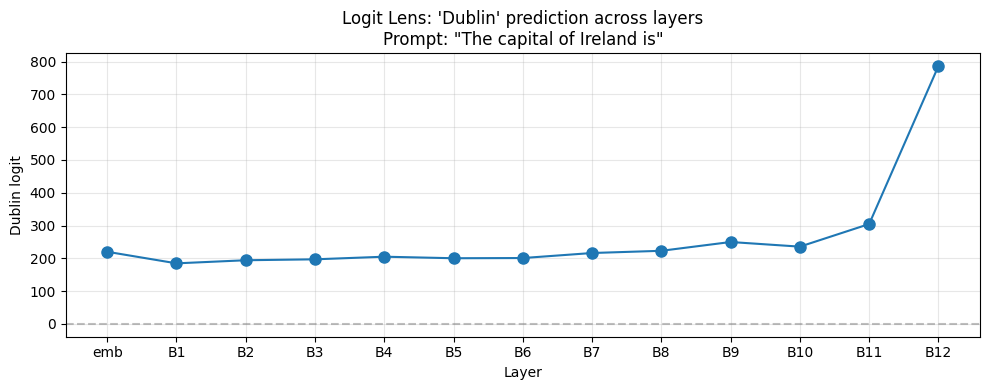

In [35]:
# Visualize the logit lens
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
x_labels = ["emb"] + [f"B{i}" for i in range(1, len(dublin_logits_by_layer))]
plt.plot(range(len(dublin_logits_by_layer)), dublin_logits_by_layer, 'o-', markersize=8)
plt.xlabel("Layer")
plt.ylabel("Dublin logit")
plt.title(f"Logit Lens: 'Dublin' prediction across layers\nPrompt: \"{prompt}\"")
plt.xticks(range(len(dublin_logits_by_layer)), x_labels)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [54]:
prompt = "As we know, the capital of Ireland is"
tokens = tokenizer(prompt, return_tensors="pt")
token_ids = tokens["input_ids"][0].tolist()
str_tokens = [tokenizer.decode([t]) for t in token_ids]

print(f"Tokens: {str_tokens}")
print(f"Token IDs: {token_ids}")

Tokens: ['As', ' we', ' know', ',', ' the', ' capital', ' of', ' Ireland', ' is']
Token IDs: [1909, 359, 871, 13, 253, 5347, 273, 11011, 310]


In [55]:
# Run the model and get all hidden states
with torch.no_grad():
    outputs = model(**tokens, output_hidden_states=True)

# outputs.hidden_states is a tuple: (embedding, layer_0_out, layer_1_out, ..., layer_L-1_out)
# So hidden_states[0] is after embedding, hidden_states[i+1] is after block i
hidden_states = outputs.hidden_states

print(f"Number of hidden states: {len(hidden_states)} (embedding + {len(hidden_states)-1} layers)")
print(f"Shape of each: {hidden_states[0].shape}")  # [batch, seq_len, d_model]

Number of hidden states: 13 (embedding + 12 layers)
Shape of each: torch.Size([1, 9, 768])


In [58]:
# Logit lens: compute logit for "Dublin" at each layer
# We look at the LAST position (where the model predicts the next token)

last_pos = -1

dublin_logits_by_layer = []

with torch.no_grad():
    for i, hidden in enumerate(hidden_states):
        # hidden[0, last_pos, :] is the residual at last position
        resid = hidden[0, last_pos, :]  # [d_model]
        
        # Apply final layer norm
        resid_normed = final_ln(resid)
        
        # Get all logits, then extract Dublin's
        logits = unembed(resid_normed)  # [vocab_size]
        dublin_logit = logits[dublin_token].item()
        dublin_logits_by_layer.append(dublin_logit)

# Label: 0 = after embedding, 1..L = after each block
print("Dublin logit at each layer:")
print(f"  After embedding: {dublin_logits_by_layer[0]:+.2f}")
for layer in range(1, len(dublin_logits_by_layer)):
    print(f"  After block {layer}: {dublin_logits_by_layer[layer]:+.2f}")

Dublin logit at each layer:
  After embedding: +219.88
  After block 1: +175.55
  After block 2: +187.23
  After block 3: +189.84
  After block 4: +195.89
  After block 5: +194.60
  After block 6: +192.15
  After block 7: +209.27
  After block 8: +216.90
  After block 9: +242.45
  After block 10: +229.26
  After block 11: +300.62
  After block 12: +786.10


In [56]:
# Also show what the model actually predicts at the final layer
final_logits = outputs.logits[0, -1, :]  # [vocab_size]

top_tokens = torch.topk(final_logits, 5)
print("Top 5 predictions after final layer:")
for i, (logit, tok_id) in enumerate(zip(top_tokens.values, top_tokens.indices)):
    token_str = tokenizer.decode([tok_id.item()])
    print(f"  {i+1}. '{token_str}' (logit: {logit:.2f})")

Top 5 predictions after final layer:
  1. ' the' (logit: 787.15)
  2. ' now' (logit: 785.98)
  3. ' a' (logit: 785.73)
  4. ' not' (logit: 785.39)
  5. ' still' (logit: 785.34)


In [59]:
prompt = "Now children, as we know, the capital of Ireland is"
tokens = tokenizer(prompt, return_tensors="pt")
token_ids = tokens["input_ids"][0].tolist()
str_tokens = [tokenizer.decode([t]) for t in token_ids]

print(f"Tokens: {str_tokens}")
print(f"Token IDs: {token_ids}")

Tokens: ['Now', ' children', ',', ' as', ' we', ' know', ',', ' the', ' capital', ' of', ' Ireland', ' is']
Token IDs: [4125, 2151, 13, 347, 359, 871, 13, 253, 5347, 273, 11011, 310]


In [64]:
# Run the model and get all hidden states
with torch.no_grad():
    outputs = model(**tokens, output_hidden_states=True)

# outputs.hidden_states is a tuple: (embedding, layer_0_out, layer_1_out, ..., layer_L-1_out)
# So hidden_states[0] is after embedding, hidden_states[i+1] is after block i
hidden_states = outputs.hidden_states

print(f"Number of hidden states: {len(hidden_states)} (embedding + {len(hidden_states)-1} layers)")
print(f"Shape of each: {hidden_states[0].shape}")  # [batch, seq_len, d_model]

Number of hidden states: 13 (embedding + 12 layers)
Shape of each: torch.Size([1, 12, 768])


In [65]:
# Logit lens: compute logit for "Dublin" at each layer
# We look at the LAST position (where the model predicts the next token)

last_pos = -1

dublin_logits_by_layer = []

with torch.no_grad():
    for i, hidden in enumerate(hidden_states):
        # hidden[0, last_pos, :] is the residual at last position
        resid = hidden[0, last_pos, :]  # [d_model]
        
        # Apply final layer norm
        resid_normed = final_ln(resid)
        
        # Get all logits, then extract Dublin's
        logits = unembed(resid_normed)  # [vocab_size]
        dublin_logit = logits[dublin_token].item()
        dublin_logits_by_layer.append(dublin_logit)

# Label: 0 = after embedding, 1..L = after each block
print("Dublin logit at each layer:")
print(f"  After embedding: {dublin_logits_by_layer[0]:+.2f}")
for layer in range(1, len(dublin_logits_by_layer)):
    print(f"  After block {layer}: {dublin_logits_by_layer[layer]:+.2f}")

Dublin logit at each layer:
  After embedding: +219.88
  After block 1: +175.46
  After block 2: +190.72
  After block 3: +186.87
  After block 4: +194.52
  After block 5: +196.56
  After block 6: +197.45
  After block 7: +213.46
  After block 8: +221.73
  After block 9: +246.20
  After block 10: +230.04
  After block 11: +301.50
  After block 12: +786.32


In [66]:
# Also show what the model actually predicts at the final layer
final_logits = outputs.logits[0, -1, :]  # [vocab_size]

top_tokens = torch.topk(final_logits, 5)
print("Top 5 predictions after final layer:")
for i, (logit, tok_id) in enumerate(zip(top_tokens.values, top_tokens.indices)):
    token_str = tokenizer.decode([tok_id.item()])
    print(f"  {i+1}. '{token_str}' (logit: {logit:.2f})")

Top 5 predictions after final layer:
  1. ' the' (logit: 786.42)
  2. ' in' (logit: 784.41)
  3. ' to' (logit: 784.20)
  4. ' a' (logit: 784.15)
  5. ' now' (logit: 784.11)
